In [1]:
from __future__ import division, print_function

import pygsti
import numpy as np
import scipy
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
seaborn.set()

/Users/kmrudin/pyGSTi/packages/pygsti/tools/matrixtools.py:23: UserWarning: Could not import Cython extension - falling back to slower pure-python routines
  _warnings.warn("Could not import Cython extension - falling back to slower pure-python routines")


## Generating the data

In [2]:
# Imports a gate set consisting of X and Y rotations by pi/2
from pygsti.construction import std1Q_XY
# Creates the long-sequence GST circuits
germs = std1Q_XY.germs
fiducials = std1Q_XY.fiducials
max_lengths = [1,2,4,8,16,32,64,128,256]
gate_sequences = pygsti.construction.make_lsgst_experiment_list(std1Q_XY.gates,fiducials,fiducials,germs,max_lengths)
print("The total number of circuits is {}".format(len(gate_sequences)))

The total number of circuits is 1405


In [3]:
#Let's make our underlying gate set have a little bit of random unitary noise.
#Choose if you want to use the same random base gate set used to generate the data for Figure 2,
#or if you want to generate your own random base gate set.

load_or_generate_gs = 'load'
#load_or_generate_gs = 'generate'

if load_or_generate_gs == 'load':
    gs_exp_0 = pygsti.io.load_gateset('Simulated_data/base_gate_set.txt')

elif load_or_generate_gs == 'generate':
    gs_exp_0 = std1Q_XY.gs_target.copy()
    gs_exp_0 = gs_exp_0.randomize_with_unitary(.01,seed=0)

In [4]:
np.random.seed(0)
np.random.randn()

1.764052345967664

In [5]:
#Now we make a list of gate sets, each with an additional 10^-3 radians of over-rotation on each gate.

gs_linear_list = []
angle_scale = 1e-3
for i in range(5):
    angle = angle_scale*i
    new_gs = gs_exp_0.copy()
    new_gs['Gx'].rotate((angle,0,0))
    new_gs['Gy'].rotate((0,angle,0))
    gs_linear_list.append(new_gs)

In [6]:
N=100
num_passes = 5

In [7]:
ds_linear_list = []

In [8]:
#Now we generate or load datasets, one for each gate set.
#If 'generate' is selected, then the data gets regenerated.
#If 'load' is selected, then the data presented in the paper is loaded 
#(which might not be the same as the regenerated data, due to random sampling.)

load_or_generate_ds = 'load'
#load_or_generate_ds = 'generate'

if load_or_generate_ds == 'load':
    for i in range(num_passes):
        print("Loading data for pass {}".format(i+1))
        ds_linear = pygsti.io.load_dataset('Simulated_data/ds_linear_'+str(i)+'.txt')
        ds_linear_list.append(ds_linear)


if load_or_generate_ds == 'generate':
    for i in range(num_passes):
        print("Generating data for pass {}".format(i+1))
        ds_linear = pygsti.construction.generate_fake_data(gs_linear_list[i],gate_sequences,N,'binomial',seed=i*10)
        ds_linear_list.append(ds_linear)


Generating data for pass 1
Generating data for pass 2
Generating data for pass 3
Generating data for pass 4
Generating data for pass 5


## Data analysis

In [9]:
# We fix the global significance of the hypothesis testing to be 5%.
global_significance_level = 0.05

In [10]:
#We perform 11 "top level" tests- 10 pairwise comparisons, and 1 comparison among all five datasets simultaneously.
number_of_toplevel_tests = 10 + 1
corrected_significance_level = global_significance_level/number_of_toplevel_tests
print(corrected_significance_level)

0.004545454545454546


In [11]:
comparators_dict = {}

In [12]:
print("--------------------------------------------------------------------")
print("------- Jointly comparing all passes (comparing {} contexts) --------".format(num_passes))
print("--------------------------------------------------------------------\n")
alldata = [ds_linear_list[i] for i in range(num_passes)]
comparators_dict['all'] = pygsti.objects.DataComparator(alldata)
comparators_dict['all'].implement(significance=corrected_significance_level)

--------------------------------------------------------------------
------- Jointly comparing all passes (comparing 5 contexts) --------
--------------------------------------------------------------------

The datasets are INCONSISTENT at 0.4545454545454546% significance.

  Details:
  - Using the composite log-likelihood ratio test, the significance of the inconsistency between datasets is 21.76812957323158 standard deviations.
  - The number of sequences with data that is inconsistent is 21


In [13]:
num_passes = 5
for i in range(num_passes):
    for j in range(i+1,num_passes):
        print("---------------------------------------------------------")
        print("--- Comparing pass {} to pass {} (comparing 2 contexts) ---".format(i+1,j+1))
        print("---------------------------------------------------------\n")
        comparators_dict[i,j] = pygsti.objects.DataComparator([ds_linear_list[i],ds_linear_list[j]])
        comparators_dict[i,j].implement(significance=corrected_significance_level)
        print('')

---------------------------------------------------------
--- Comparing pass 1 to pass 2 (comparing 2 contexts) ---
---------------------------------------------------------

Statistical hypothesis tests did NOT find inconsistency between the datasets at 0.4545454545454546% significance.


---------------------------------------------------------
--- Comparing pass 1 to pass 3 (comparing 2 contexts) ---
---------------------------------------------------------

The datasets are INCONSISTENT at 0.4545454545454546% significance.

  Details:
  - Using the composite log-likelihood ratio test, the significance of the inconsistency between datasets is 9.097690736410733 standard deviations.
  - The number of sequences with data that is inconsistent is 0

---------------------------------------------------------
--- Comparing pass 1 to pass 4 (comparing 2 contexts) ---
---------------------------------------------------------

The datasets are INCONSISTENT at 0.4545454545454546% significance.


In [14]:
#Post-process the data, sorting the LLRs by sequence length
gate_sequence_gens = pygsti.construction.make_lsgst_lists(std1Q_XY.gates,fiducials,fiducials,germs,max_lengths)
gate_sequence_family_dict = {}
for gate_seq in gate_sequences:
    generation = 0
    while gate_seq not in gate_sequence_gens[generation]:
        generation += 1
    gate_sequence_family_dict[gate_seq] = 2**generation

In [15]:
pseudo_threshold = comparators_dict[0,4].get_LLR_pseudothreshold()

## Plotting the results

Text(0,0.5,'Jensen-Shannon Divergence')

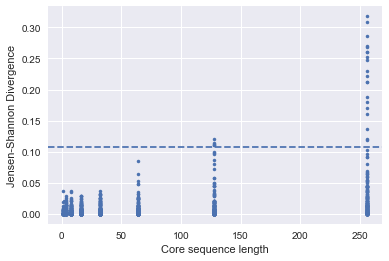

In [24]:
#Plot JSD vs core sequence length for the comparison between the gate set with no additional over-rotation
#and the gate set with 4*10^-3 radians of additional over rotation
plt.plot([gate_sequence_family_dict[gate_seq] for gate_seq in gate_sequences],[comparators_dict[0,4].llrs[gate_seq]/(2*N) for gate_seq in gate_sequences],'.')
plt.axhline(pseudo_threshold/(2*N), linestyle='--')
plt.xlabel('Core sequence length')
plt.ylabel('Jensen-Shannon Divergence')

In [40]:
#Now let's break down the above LLRs by whether or not the sequence's germ consists of just 
#an X-pi/2 gate, a Y-pi/2 gate, or a combination of X- and Y-pi/2 gates.

In [36]:
germs

[GateString(Gx),
 GateString(Gy),
 GateString(GxGy),
 GateString(GxGxGy),
 GateString(GxGyGy),
 GateString(GxGxGyGxGyGy)]

In [37]:
x_only_germs = germs[:1]
y_only_germs = germs[1:2]
other_germs = germs[2:]

x_seqs = pygsti.construction.make_lsgst_experiment_list(std1Q_XY.gates,fiducials,fiducials,x_only_germs,max_lengths)
y_seqs = pygsti.construction.make_lsgst_experiment_list(std1Q_XY.gates,fiducials,fiducials,y_only_germs,max_lengths)
other_seqs = pygsti.construction.make_lsgst_experiment_list(std1Q_XY.gates,fiducials,fiducials,other_germs,max_lengths)

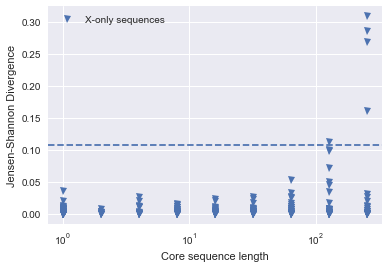

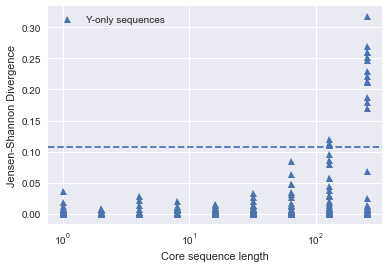

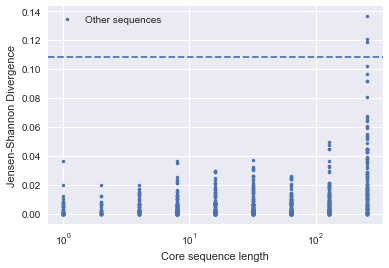

In [44]:
plt.plot([gate_sequence_family_dict[gate_seq] for gate_seq in x_seqs],
         [comparators_dict[0,4].llrs[gate_seq]/(2*N) for gate_seq in x_seqs],'v',label='X-only sequences')
plt.axhline(pseudo_threshold/(2*N), linestyle='--')
plt.legend()
plt.xlabel('Core sequence length')
plt.ylabel('Jensen-Shannon Divergence')
plt.xscale('log')
plt.show()

plt.plot([gate_sequence_family_dict[gate_seq] for gate_seq in y_seqs],
         [comparators_dict[0,4].llrs[gate_seq]/(2*N) for gate_seq in y_seqs],'^',label='Y-only sequences')
plt.axhline(pseudo_threshold/(2*N), linestyle='--')
plt.legend()
plt.xlabel('Core sequence length')
plt.ylabel('Jensen-Shannon Divergence')
plt.xscale('log')
plt.show()

plt.plot([gate_sequence_family_dict[gate_seq] for gate_seq in other_seqs],
         [comparators_dict[0,4].llrs[gate_seq]/(2*N) for gate_seq in other_seqs],'.',label='Other sequences')
plt.axhline(pseudo_threshold/(2*N), linestyle='--')
plt.legend()
plt.xlabel('Core sequence length')
plt.ylabel('Jensen-Shannon Divergence')
plt.xscale('log')
plt.show()

In [43]:
#We can also visualize this data in another way.
#Each pixel corresponds to a gate sequence; it is shaded according to its LLR.
#Note that some circuits show up as multiple pixels in a plot.  Mouse over a pixel for more information;
#"value" refers to log-likelihood ratio.

w = pygsti.report.Workspace()
w.init_notebook_mode(connected=False, autodisplay=True) 

gssList = pygsti.construction.make_lsgst_structs(['Gx','Gy'], fiducials, fiducials, germs, max_lengths)

w.ColorBoxPlot('dscmp', gssList[-1], None, None, dscomparator=comparators_dict[0,4])